# Training loop draft 3
J. Cristiano

*BINARY SEGMENTATION*      
This is the training loop thats gonna have all the moving parts in it:     
- Data Augmentation 
- Weighted Cross entropy loss
- Transfer learning

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
coco_root = '/work/2024_annot/images'
coco_annFile = '/work/2024_annot/2024_annotations.json'
standard_transform = transforms.v2.Compose([
    v2.CenterCrop(2048), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
full_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("boxes", "labels", "masks"))

train_size = int(0.8 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
test_size += len(full_dataset) - (train_size + test_size)
full_dataset.train, full_dataset.test = torch.utils.data.random_split(full_dataset, [train_size, test_size])

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [11]:
augmentations = transforms.v2.Compose([
    transforms.v2.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    
])

def custom_collate_fn(batch):
    # Unpack the batch - assuming each item is a (image, mask) tuple
    images, masks = zip(*batch)
    binary_mask_batch = []
    for mask in masks:
        binary = torch.max(mask["masks"], dim=0)[0]
        binary_mask_batch.append(binary)
    return images, masks

full_dataset.train.transforms = transforms.v2.Compose([standard_transform, augmentations])
train_dataloader = DataLoader(
    full_dataset.train, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)
test_dataloader = DataLoader(
    full_dataset.test, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)

In [12]:
# Calculate class weights for weighted cross entropy
class_counts = torch.zeros(2)  # 2 classes
total_pixels = 0
print("Calculating class imbalances")
for _, masks in tqdm(train_dataloader):
    
    for mask in masks:
        mask = mask["masks"]
        binary_mask = torch.max(mask, dim=0)
        total_pixels += binary_mask.values.numel()
        class_counts[1] += binary_mask.values.sum()
        class_counts[0] += binary_mask.values.numel() - binary_mask.values.sum()
class_weights = 1.0 / (class_counts + 1e-8)  # add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normalize weights
print(f"Class weights: {class_weights}")

Calculating class imbalances


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.48it/s]

Class weights: tensor([0.3906, 1.6094])


In [ ]:
#training loop 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn


preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
model.to(device)
criterion = nn.CrossEntropyLoss(class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
training_results = {
    "train_loss": [],
    "test_loss" : [], 
    "pocket_loss": None,
    "pocket_model": None,
}
for epoch in range(50):
    running_loss = 0.0
    for img, mask in tqdm(train_dataloader):
        model.train()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        combined_mask = torch.stack([torch.max(m["masks"], dim=0)[0] for m in mask])
        loss = criterion(result.to(device), combined_mask.long().to(device))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_results["train_loss"].append(running_loss/len(train_dataloader))
    running_loss = 0.0
    for img, mask in tqdm(test_dataloader):
        model.eval()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        combined_mask = torch.stack([torch.max(m["masks"], dim=0)[0] for m in mask])
        loss = criterion(result.to(device), combined_mask.long().to(device))
        running_loss += loss.item()
    training_results["test_loss"].append(running_loss/len(test_dataloader))    
    
    if training_results["pocket_loss"] == None or  training_results["train_loss"][-1] < training_results["pocket_loss"]:
            training_results["pocket_loss"] = loss.item()
            training_results["pocket_model"] = model.state_dict().copy()
    print(f"Epoch {epoch} - Loss: {training_results['train_loss'][-1]}")
    print(f"Epoch {epoch} - Test Loss: {training_results['test_loss'][-1]}")



# plot([img, combined_mask])
# plot(result.squeeze().detach().cpu().numpy())


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 0 - Loss: 0.38963585008274426
Epoch 0 - Test Loss: 12.060296853383383


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch 1 - Loss: 0.15863951363346793
Epoch 1 - Test Loss: 0.18217900395393372


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 2 - Loss: 0.11116319691592996
Epoch 2 - Test Loss: 0.4924243787924449


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 3 - Loss: 0.09536799111149528
Epoch 3 - Test Loss: 0.12147477020819981


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 4 - Loss: 0.10042031515728343
Epoch 4 - Test Loss: 0.16067655881245932


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 5 - Loss: 0.0889304903420535
Epoch 5 - Test Loss: 0.09465202689170837


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 6 - Loss: 0.07697593793272972
Epoch 6 - Test Loss: 0.09114111214876175


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 7 - Loss: 0.06530505554242567
Epoch 7 - Test Loss: 0.09063250571489334


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 8 - Loss: 0.059521263634616677
Epoch 8 - Test Loss: 0.06861066569884618


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 9 - Loss: 0.05266107449477369
Epoch 9 - Test Loss: 0.07259763528903325


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 10 - Loss: 0.050449775023893875
Epoch 10 - Test Loss: 0.09429246932268143


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 11 - Loss: 0.05179325812919573
Epoch 11 - Test Loss: 0.35774985949198407


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 12 - Loss: 0.058937316252426666
Epoch 12 - Test Loss: 0.162505105137825


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 13 - Loss: 0.0547796907750043
Epoch 13 - Test Loss: 0.10181431969006856


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 14 - Loss: 0.05685547569935972
Epoch 14 - Test Loss: 0.08594559381405513


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 15 - Loss: 0.06217353045940399
Epoch 15 - Test Loss: 0.0816350057721138


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


Epoch 16 - Loss: 0.050597096708687866
Epoch 16 - Test Loss: 0.06894497573375702


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 17 - Loss: 0.047720489515499634
Epoch 17 - Test Loss: 0.07048833866914113


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 18 - Loss: 0.04489227452061393
Epoch 18 - Test Loss: 0.06836489588022232


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 19 - Loss: 0.04307293891906738
Epoch 19 - Test Loss: 0.08680237829685211


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 20 - Loss: 0.04237412187186154
Epoch 20 - Test Loss: 0.0964004968603452


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 21 - Loss: 0.038512633605436844
Epoch 21 - Test Loss: 0.06908159082134564


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 22 - Loss: 0.03758120333606547
Epoch 22 - Test Loss: 0.0915937473376592


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch 23 - Loss: 0.036795904182574966
Epoch 23 - Test Loss: 0.09189743300278981


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 24 - Loss: 0.03159053166481582
Epoch 24 - Test Loss: 0.07936651135484378


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 25 - Loss: 0.028861281885342163
Epoch 25 - Test Loss: 0.0876533252497514


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 26 - Loss: 0.02739503471688791
Epoch 26 - Test Loss: 0.06507291023929913


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 27 - Loss: 0.02516902746124701
Epoch 27 - Test Loss: 0.07628940045833588


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 28 - Loss: 0.023458504541353745
Epoch 28 - Test Loss: 0.09113621711730957


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 29 - Loss: 0.023029632019725712
Epoch 29 - Test Loss: 0.08924156179030736


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 30 - Loss: 0.022112948819994926
Epoch 30 - Test Loss: 0.08758838723103206


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 31 - Loss: 0.020695989951491356
Epoch 31 - Test Loss: 0.08843989918629329


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 32 - Loss: 0.020201751284978607
Epoch 32 - Test Loss: 0.09066032618284225


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 33 - Loss: 0.0190904200585051
Epoch 33 - Test Loss: 0.09021112322807312


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 34 - Loss: 0.018650824966078453
Epoch 34 - Test Loss: 0.0853189875682195


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 35 - Loss: 0.019194817339832134
Epoch 35 - Test Loss: 0.08087722460428874


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 36 - Loss: 0.0197262443094091
Epoch 36 - Test Loss: 0.08342609057823817


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 37 - Loss: 0.02073836512863636
Epoch 37 - Test Loss: 0.08744675417741139


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 38 - Loss: 0.019077183848077602
Epoch 38 - Test Loss: 0.08994846791028976


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch 39 - Loss: 0.01814626157283783
Epoch 39 - Test Loss: 0.09554687887430191


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 40 - Loss: 0.017850111915983936
Epoch 40 - Test Loss: 0.11021557450294495


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 41 - Loss: 0.017942165363241325
Epoch 41 - Test Loss: 0.10780801872412364


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 42 - Loss: 0.016521824947135014
Epoch 42 - Test Loss: 0.10504756371180217


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 43 - Loss: 0.01560172624886036
Epoch 43 - Test Loss: 0.09617159763971965


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 44 - Loss: 0.015388244339688257
Epoch 44 - Test Loss: 0.11074432233969371


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 45 - Loss: 0.016230895691974598
Epoch 45 - Test Loss: 0.08602243661880493


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 46 - Loss: 0.0162876494736834
Epoch 46 - Test Loss: 0.10834355403979619


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 47 - Loss: 0.01615129927681251
Epoch 47 - Test Loss: 0.11207666993141174


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 48 - Loss: 0.01557554059069265
Epoch 48 - Test Loss: 0.11251860111951828


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

Epoch 49 - Loss: 0.01458905611864545
Epoch 49 - Test Loss: 0.12188019355138142


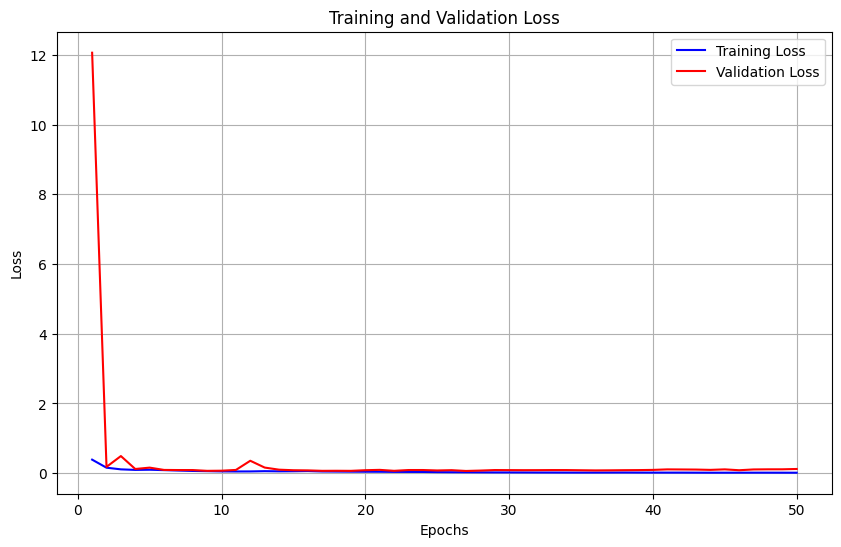

In [14]:
def plot_training_history(train_loss, test_loss, save_path=None):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, test_loss, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
plot_training_history(training_results["train_loss"], training_results["test_loss"])

In [15]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.datasets.coco import CocoDetection

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

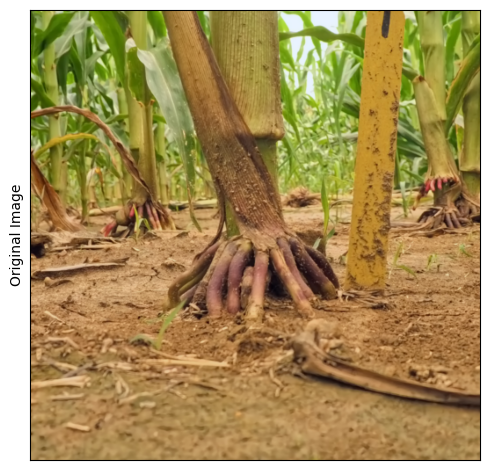

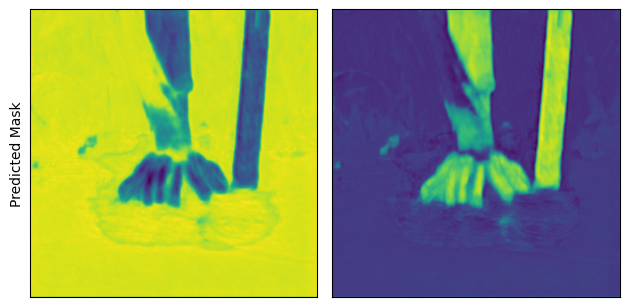

In [16]:
image, target = full_dataset.test[5]
image = torch.tensor(preprocess_input(image.permute(1, 2, 0).numpy()))
image = image.permute(2, 0, 1).unsqueeze(0).float()
result = model(image.to(device))
plot(image, row_title=["Original Image"])
plot(result.squeeze().detach().cpu().numpy(), row_title=["Predicted Mask"])